# Energy Monte Carlo

I'm going to try a rough draft simulation using rough numbers from the surveys and point estimates of appliance demand.  The xray code seems easy enough to use, so I'll stick with it.

There is only one source of variance in this simulation, the binomial variance.  If we draw the energy per day from a distribution, we will also have that as a source of variance.  We would like to lower the variance as much as possible in the forecast, but my hunch is that you need a different distribution for the appliance ownership than binomial and bernoulli to do that.

In [1]:
%matplotlib inline
import numpy as np
import xray
from scipy.stats import binom
import matplotlib.pyplot as plt

I create a table of values using pandas and give the index and columns labels.

In [2]:
import pandas as pd
proportions = pd.Series({'TV':0.80, 'radio': 0.40, 'lighting':0.90, 'fridge':0.30, 'fan':0.18, 'rice_cooker':0.25})
daily_energy = pd.Series({'TV':0.20, 'radio': 0.03, 'lighting':0.25, 'fridge':1, 'fan':0.5, 'rice_cooker':0.5})
appliance_data = pd.DataFrame({'proportions':proportions, 'daily_energy':daily_energy})
appliance_data.index.name = 'appliance'
appliance_data.columns.name = 'values'
appliance_data

values,daily_energy,proportions
appliance,,
TV,0.20,0.80
fan,0.50,0.18
fridge,1.00,0.30
lighting,0.25,0.90
radio,0.03,0.40
rice_cooker,0.50,0.25


In [3]:
appliance_data = xray.Dataset.from_dataframe(appliance_data)
#appliance_data

In [4]:
# create an array with the proportions of each appliance for each trial
num_trials = 10000
appliance = appliance_data['appliance'].values
data = np.ones((num_trials, len(appliance)))
trials = np.arange(num_trials)
sim = xray.DataArray(data, coords=[trials, appliance], dims=['trials', 'appliance'])
# broadcast multiply by the table above
sim = sim * appliance_data['proportions']
#sim

In [5]:
# perform a binomial sample over each element of array to get number of appliances
# I want a cleaner way to do this
# can I extend a ufunc so that I get a xray object back?
num_households = 100
data = binom.rvs(num_households, sim)
appliance_sim = xray.DataArray(data, coords=[trials, appliance], dims=['trials', 'appliance'])
#appliance_sim

In [6]:
# multiply by daily energy
energy_sim = appliance_sim * appliance_data['daily_energy']
#energy_sim

In [7]:
# sum over appliances
daily_simulations = energy_sim.sum('appliance') / num_households

In [8]:
print('The daily energy distribution has a mean of {} and stdev of {}'.format(daily_simulations.mean().data,
                                                                              daily_simulations.std().data))

The daily energy distribution has a mean of 0.9116067499999999 and stdev of 0.055216886814067126


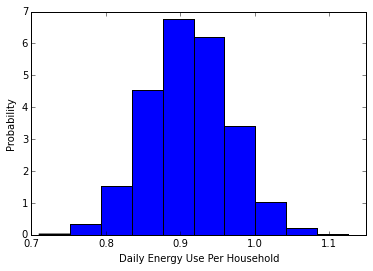

In [9]:
plt.hist(daily_simulations, normed=True)
plt.xlabel('Daily Energy Use Per Household')
plt.ylabel('Probability')
plt.show()